In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m3 import M3 
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape



# Load the M4 dataset
m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-12 14:25:47,702	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-12 14:25:48,039	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 54

     data        trend    seasonal    remainder
0  2640.0  2950.835025   67.781202  -378.616227
1  2640.0  2978.237084  268.341708  -606.578791
2  2160.0  3003.786142 -662.887103  -180.899038
3  4200.0  3028.493793 -199.896689  1371.402896
4  3360.0  3053.581366  134.299063   172.119571


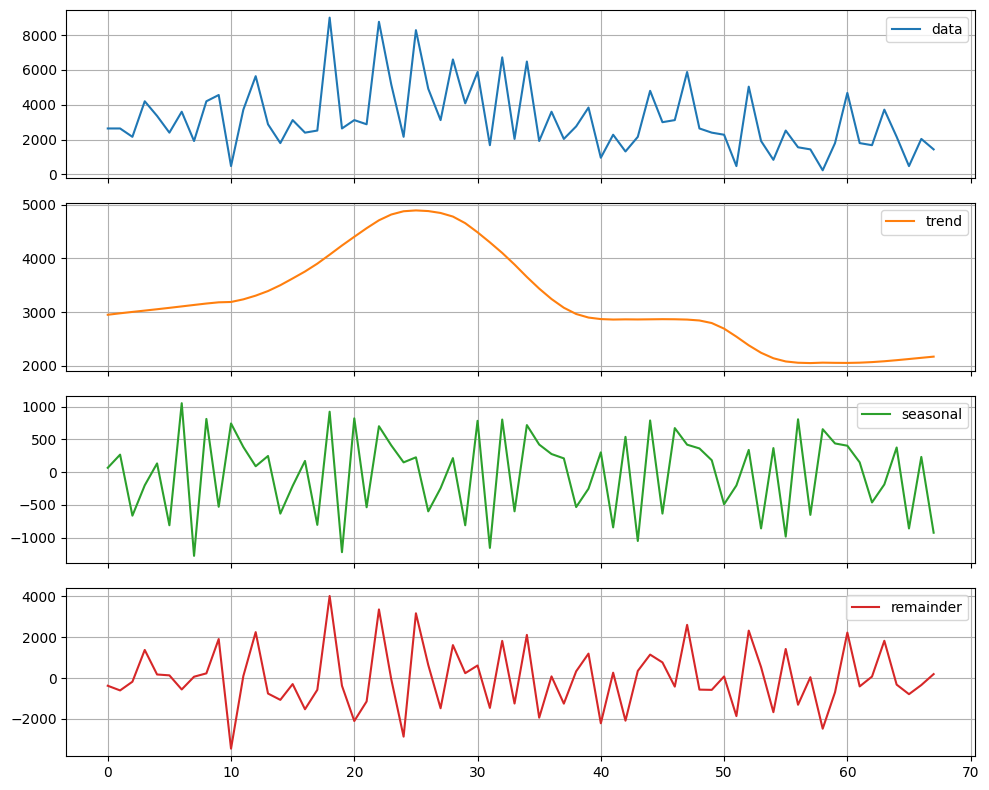

In [4]:
# decompose the time series
from statsforecast.models import MSTL
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

sf =  StatsForecast(models=[MSTL(season_length=[12] )], freq="M")
sf.fit(m3)

decomposition = sf.fitted_[0, 0].model_
print(decomposition.head())

# Plot the decomposed components: observed, trend, seasonal, and remainder.
decomposition.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

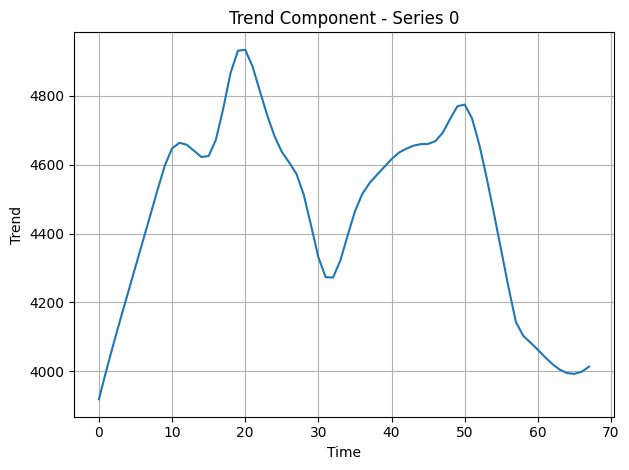

In [5]:
# Create datasets from decomposed components
trend = pd.DataFrame([sf.fitted_[i, 0].model_['trend'].values for i in range(len(sf.fitted_))])
seasonal = pd.DataFrame([sf.fitted_[i, 0].model_['seasonal'].values for i in range(len(sf.fitted_))])
remainder = pd.DataFrame([sf.fitted_[i, 0].model_['remainder'].values for i in range(len(sf.fitted_))])

# Plot the trend of the first series
plt.plot(trend.iloc[1])
plt.title("Trend Component - Series 0")
plt.xlabel("Time")
plt.ylabel("Trend")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def convert_to_nixtla_format(df, component_name="trend", time_index=None):
    long_df = df.copy()
    long_df["unique_id"] = [f"series_{i}" for i in range(len(df))]
    long_df = long_df.melt(id_vars=["unique_id"], var_name="time_idx", value_name="y")


    long_df["ds"] = long_df["time_idx"].astype(int)

    long_df = long_df[["unique_id", "ds", "y"]]

    #remove nan
    long_df = long_df.dropna()
    
    return long_df

trend_ds = convert_to_nixtla_format(trend, "trend")
seasonal_ds = convert_to_nixtla_format(seasonal, "seasonal")
remainder_ds = convert_to_nixtla_format(remainder, "remainder")


In [7]:
# create test and train datasets

Y_train_trend, Y_test_trend = train_test_split(trend_ds, horizon)
Y_train_seasonal, Y_test_seasonal = train_test_split(seasonal_ds, horizon)
Y_train_remainder, Y_test_remainder = train_test_split(remainder_ds, horizon)

Y_train_trend

,unique_id,ds,y
0,series_0,0,2950.835025
1,series_0,1,2978.237084
2,series_0,2,3003.786142
3,series_0,3,3028.493793
4,series_0,4,3053.581366
...,...,...,...
141853,series_999,121,3685.142400
141854,series_999,122,3701.610811
141855,series_999,123,3721.669990
141856,series_999,124,3744.951467


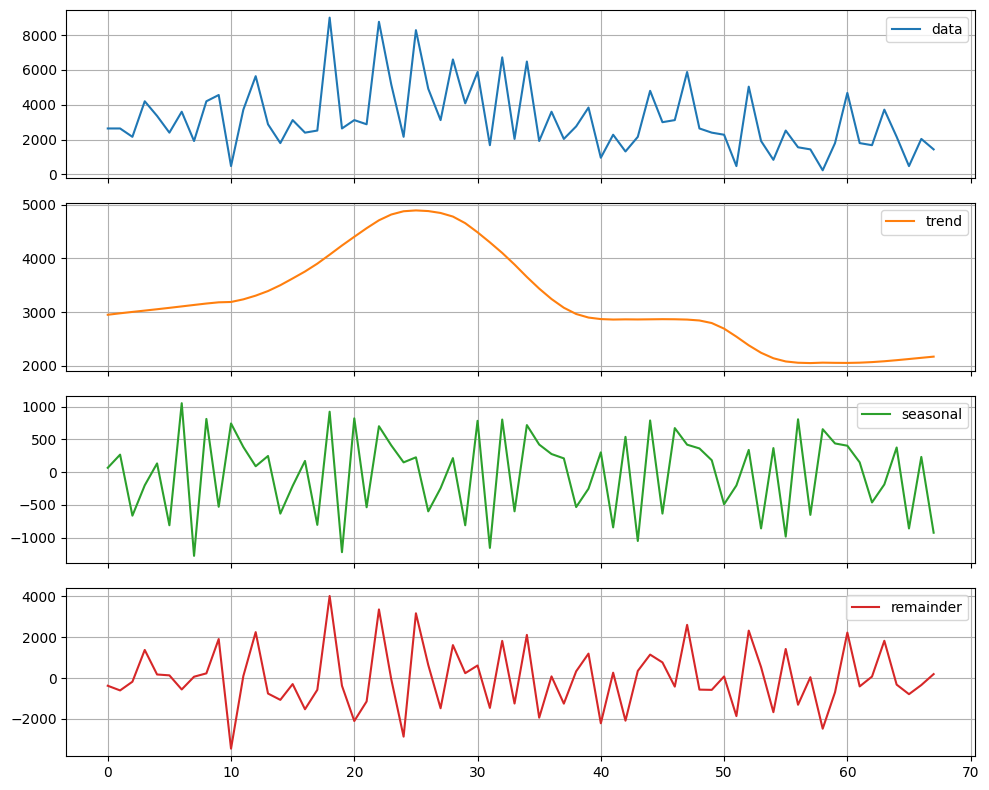

In [8]:
sf.fitted_[0, 0].model_.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

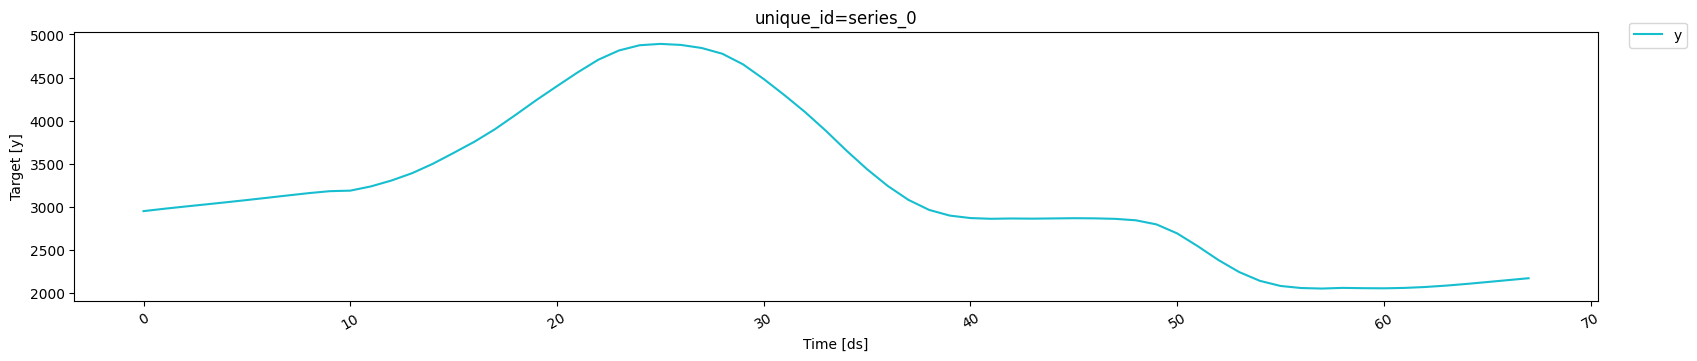

In [9]:
# plot series_0 from trend~
plot_series(Y_train_trend, Y_test_trend, ids=['series_0'])



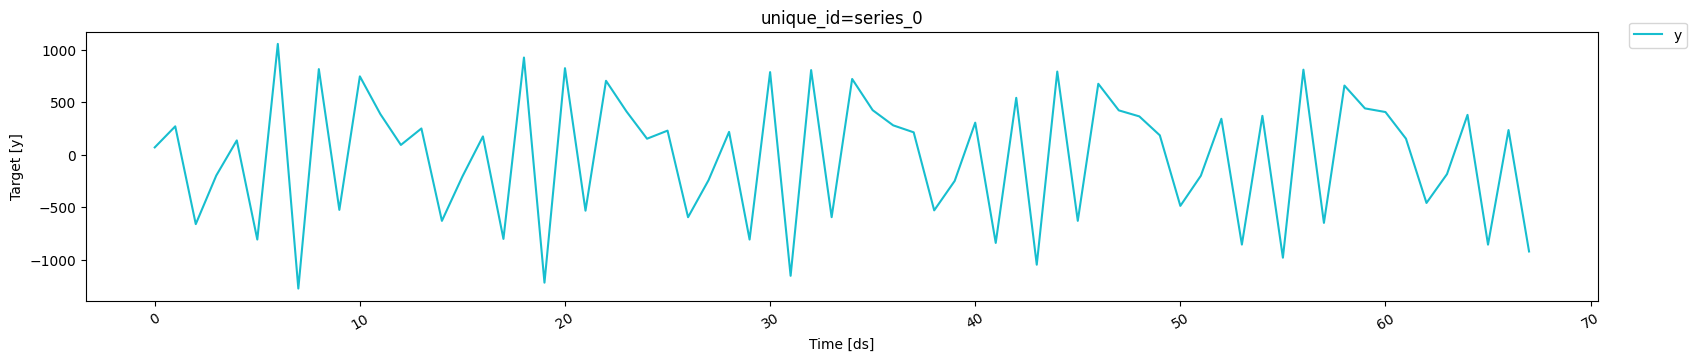

In [10]:
plot_series(Y_train_seasonal, Y_test_seasonal, ids=['series_0'])

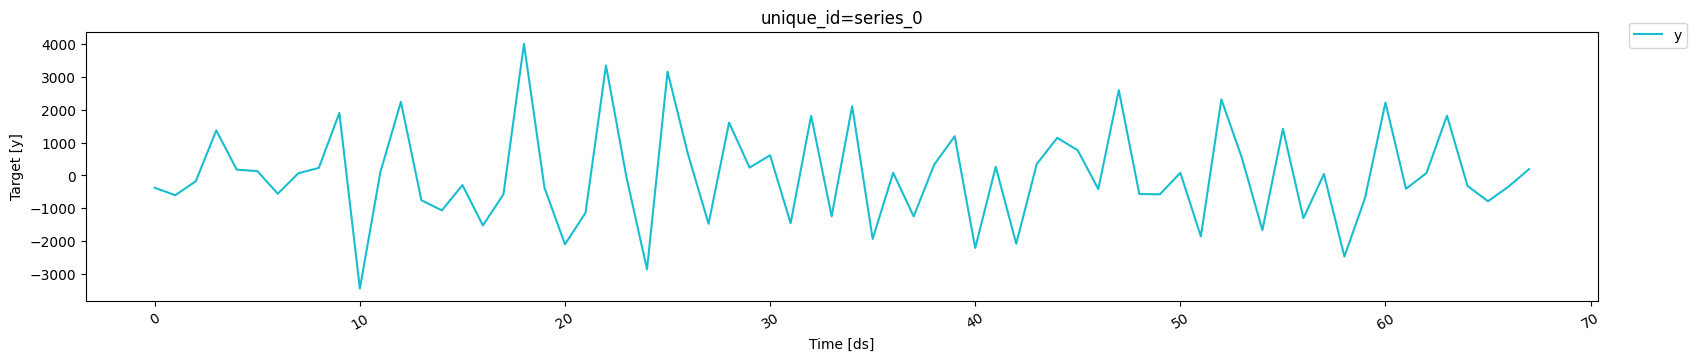

In [11]:
plot_series(Y_train_remainder, Y_test_remainder, ids=['series_0'])

In [12]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except KeyError as exc:
        raise KeyError(
            f"Forecast column '{forecast_col}' not found in predictions!") from exc
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

First the trend component ...

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.02it/s, v_num=210, train_loss_step=222.0, train_loss_epoch=255.0, valid_loss=288.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 14.96it/s, v_num=210, train_loss_step=222.0, train_loss_epoch=255.0, valid_loss=288.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 130.81it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[1305,   89, 1421],
        [1249,  873, 1299],
        [1393,  193, 1254],
        [ 802, 1274,  804],
        [ 806,  800, 1260],
        [ 214,  181, 1230],
        [1136,  370,  637],
        [ 711,  419,  226],
        [ 212,  396,  141],
        [ 172,  179, 1226]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.6496, 0.8632, 0.6568],
        [0.6492, 0.8511, 0.5665],
        [0.6225, 0.8403, 0.5625],
        [0.6199, 0.8397, 0.5582],
        [0.6185, 0.8312, 0.5545],
        [0.6183, 0.8294, 0.5361],
        [0.6061, 0.8213, 0.5339],
        [0.6006, 0.8210, 0.5172],
        [0.5967, 0.8196, 0.5128],
        [0.5897, 0.8178, 0.4907]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([4796.0049, 4783.9062, 4769.4624, 4757.1772, 4748.1030, 4738.4253,
        4725.9321, 4709.1099, 4686.5654, 4658.6367, 4628.6821, 460

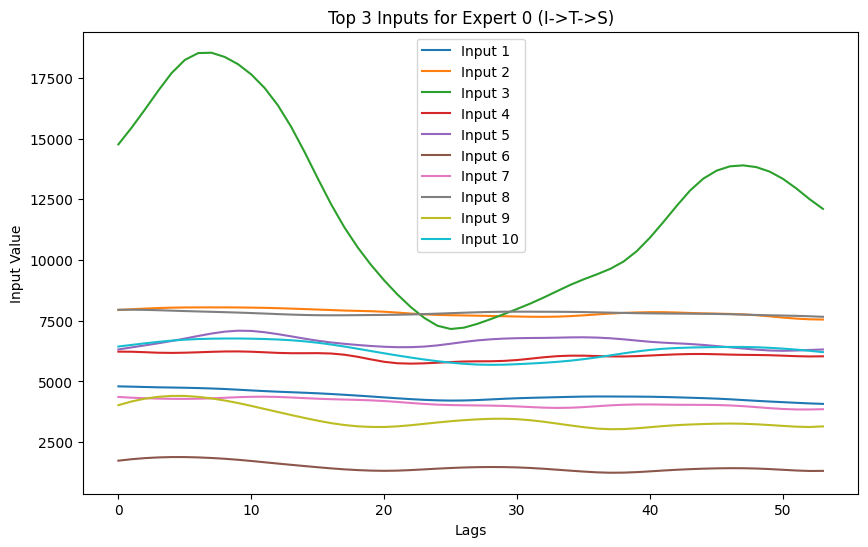

expert_top_inputs[:, 0]: tensor([4769.8257, 4784.2300, 4804.3408, 4826.6685, 4849.7119, 4873.5981,
        4898.8262, 4926.3398, 4956.1675, 4986.2012, 5013.8613, 5037.7061,
        5056.5854, 5068.4595, 5069.6304, 5056.8564, 5032.5156, 5003.6582,
        4977.8716, 4959.2822, 4947.5757, 4940.6860, 4935.9526, 4931.1553,
        4926.1260, 4923.1841, 4925.6904, 4936.0278, 4952.5010, 4970.2251,
        4984.2935, 4991.6567, 4992.4302, 4989.4819, 4986.8315, 4984.5034,
        4978.7739, 4967.2881, 4951.6421, 4935.5732, 4921.1064, 4908.5469,
        4898.1719, 4891.0591, 4888.9941, 4892.5435, 4901.5859, 4918.0981,
        4943.9692, 4977.9609, 5015.0815, 5048.4429, 5071.9009, 5082.1548],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([5150.4751, 5179.7104, 5206.1929, 5228.9321, 5247.4688, 5261.8750,
        5272.4741, 5279.7759, 5284.6729, 5288.4619, 5292.2852, 5297.0303,
        5303.3081, 5311.1914, 5320.8867, 5332.7012, 5346.8730, 5363.5547,
        5382.5078, 5402.7080, 5422.67

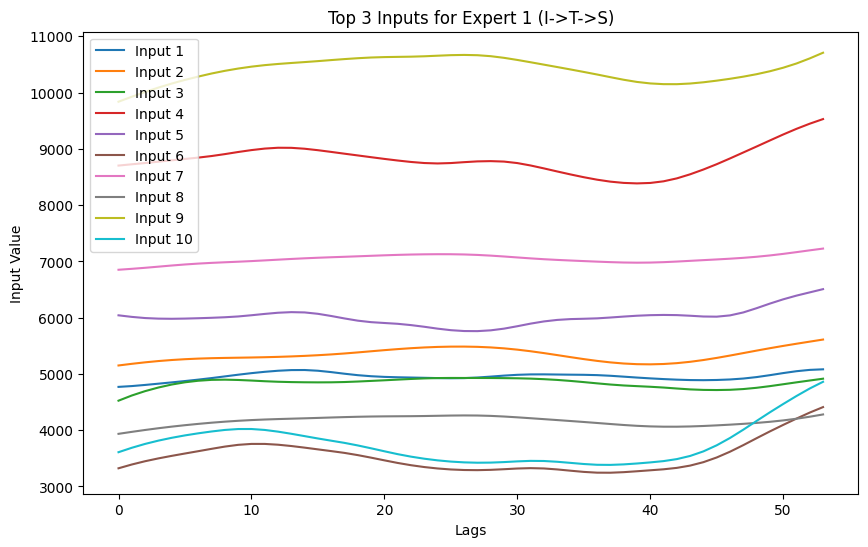

expert_top_inputs[:, 0]: tensor([2188.8630, 2169.8308, 2141.6189, 2106.3120, 2067.7004, 2027.4281,
        1989.7274, 1957.7307, 1932.0225, 1913.8905, 1905.6648, 1907.1652,
        1917.0762, 1935.3174, 1959.6029, 1987.5430, 2016.3839, 2044.8285,
        2073.9163, 2105.6709, 2141.6912, 2180.2400, 2214.9546, 2239.2717,
        2251.5317, 2253.4937, 2249.7146, 2245.8154, 2244.0867, 2241.7490,
        2232.2183, 2209.2561, 2171.4827, 2125.2017, 2082.4412, 2054.7815,
        2048.7319, 2065.6377, 2100.1321, 2143.3381, 2187.2478, 2226.8538,
        2259.8206, 2286.0027, 2305.3247, 2316.2205, 2313.8479, 2294.4534,
        2254.6160, 2192.9900, 2115.5952, 2031.5350, 1950.0767, 1878.3301],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([4793.8809, 4787.4893, 4779.0337, 4769.6172, 4758.9746, 4747.4224,
        4736.3853, 4727.0908, 4719.9600, 4714.5938, 4711.5845, 4711.0356,
        4713.2554, 4718.0879, 4725.1494, 4733.4219, 4741.4893, 4748.3540,
        4754.1489, 4759.3931, 4765.24

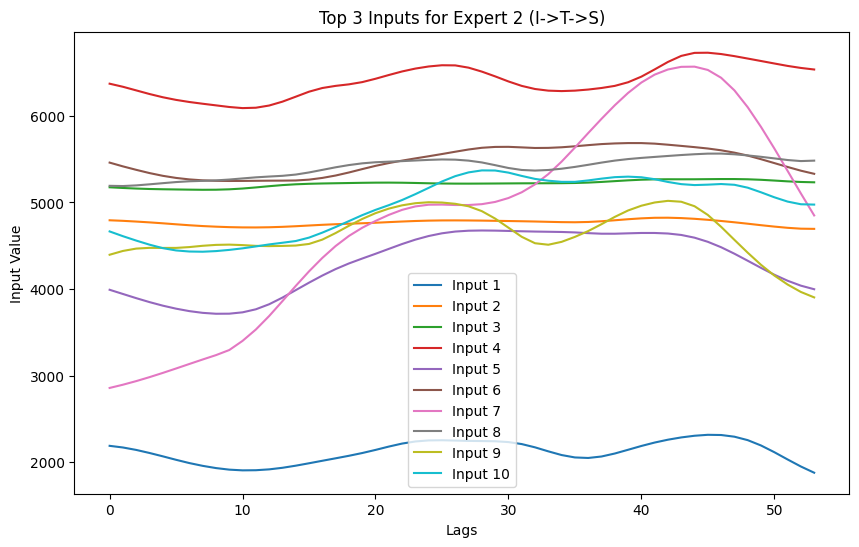

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 40.23it/s] 
sMAPE for trend: 0.06463145824018021


In [13]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_trend, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_trend)

smape_trend = calculate_smape(Y_test_trend, predictions, 'NBeatsStackMoe')
print(f'sMAPE for trend: {smape_trend}')

... now the seasonal component ...

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 14.86it/s, v_num=212, train_loss_step=47.20, train_loss_epoch=56.40, valid_loss=38.50]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 14.82it/s, v_num=212, train_loss_step=47.20, train_loss_epoch=56.40, valid_loss=38.50]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 131.54it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[ 477, 1379,  906],
        [ 317, 1380, 1384],
        [ 619,  704,   84],
        [ 380,  705,  263],
        [ 328,  788,  818],
        [ 409,  567, 1417],
        [  47,  949,  745],
        [1302,  697,  342],
        [ 812,  440,  458],
        [   5,  541,  339]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.3877, 0.3878, 0.4726],
        [0.3831, 0.3816, 0.4683],
        [0.3814, 0.3778, 0.4655],
        [0.3808, 0.3738, 0.4632],
        [0.3804, 0.3659, 0.4623],
        [0.3800, 0.3576, 0.4620],
        [0.3770, 0.3548, 0.4604],
        [0.3739, 0.3457, 0.4597],
        [0.3727, 0.3450, 0.4593],
        [0.3726, 0.3443, 0.4591]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([ -1.0439,   0.0349,  -1.6653,   5.7916,   2.5212,   1.4074,   2.0065,
          3.6086,  -1.8553,  -2.0649,  -7.5798,  -4.1987,  -1.

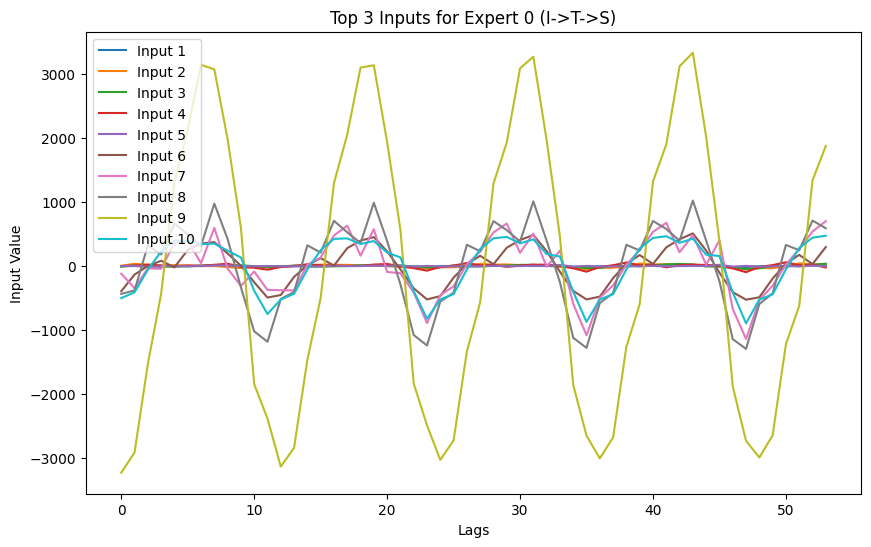

expert_top_inputs[:, 0]: tensor([-67.3666,   1.3340, -10.2639,  -9.5409,  37.7706,  92.8276, 211.3766,
        -94.6639, -82.5192, -23.0542, -24.1321, -27.4359, -52.1128,   6.2512,
          0.9194,   3.4930,   7.5853,  53.0884, 139.2003, -60.9962, -59.5387,
        -25.4981,  15.1240, -14.1903, -44.6048,  17.9733,   9.6609,   5.5344,
        -12.1008,  23.6343,  82.0180, -43.4908, -43.9547, -29.3699,  47.6066,
         -0.3931, -41.0540,  22.8799,  12.5106,   5.4513, -20.9865,   8.7144,
         53.5623, -36.0225, -36.4700, -31.9219,  64.3690,   5.4114, -38.4630,
         24.7331,  13.7506,   6.1336, -25.9018,  -0.3407], device='cuda:0')
expert_top_inputs[:, 1]: tensor([ -65.6674,   -7.1037,  -13.6590,  -18.6129,   20.9139,  129.1577,
         213.4850,  -95.6615, -101.4374,  -49.5520,    6.9513,  -18.3801,
         -49.7614,    1.4366,   -1.2954,   -7.2917,   -1.6285,   79.2376,
         138.9139,  -60.7928,  -74.4808,  -40.6611,   38.4100,   -9.2288,
         -42.6304,   14.0593,   

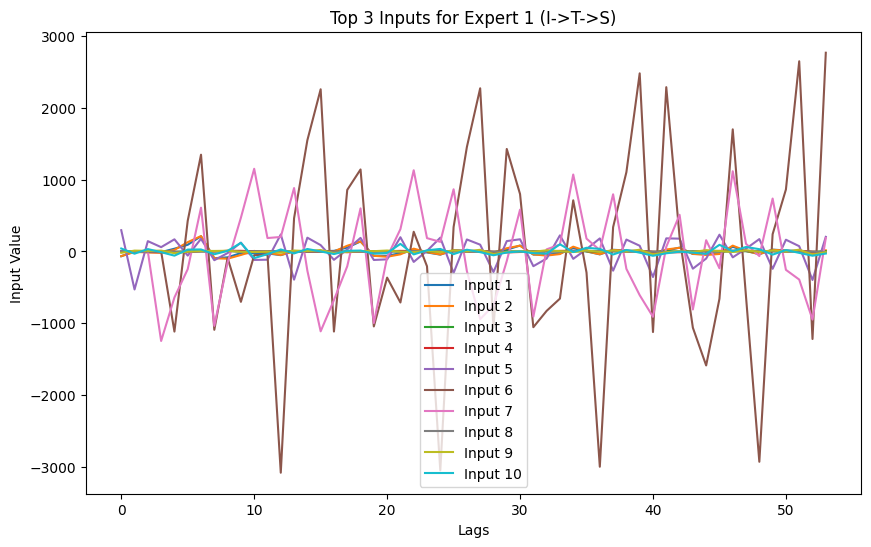

expert_top_inputs[:, 0]: tensor([   0.0000,    0.0000,    0.0000,  234.5952, -688.9744, -214.9606,
        -605.5386, -392.4296, -487.5492,  326.6635,  549.5355,  384.8896,
        1195.2308,  126.1885, -450.6879,  248.2503, -645.6439, -215.2148,
        -604.1557, -396.2943, -496.4294,  334.8769,  506.1884,  379.4458,
        1143.6626,  124.8039, -412.9933,  274.3815, -581.3995, -234.1189,
        -588.1132, -395.7514, -520.2245,  340.5886,  432.1693,  360.2643,
        1055.7661,  140.7667, -336.6978,  300.4305, -447.8188, -262.9440,
        -569.5156, -402.7830, -509.2592,  347.8505,  292.5233,  325.9291,
         995.9319,  151.3843, -267.8243,  286.9547, -358.7782, -251.2274],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([ 90.9373,  54.3570,  75.9271,  38.9492,  -7.5468, -23.6298, -29.9324,
        -31.2340, -22.8279, -60.4362, -40.5052,  -2.0003,  73.2356,  39.1130,
         51.7402,  19.6079, -23.2112, -15.7305, -28.0218, -34.5417, -10.5057,
        -22.2406,  -2.401

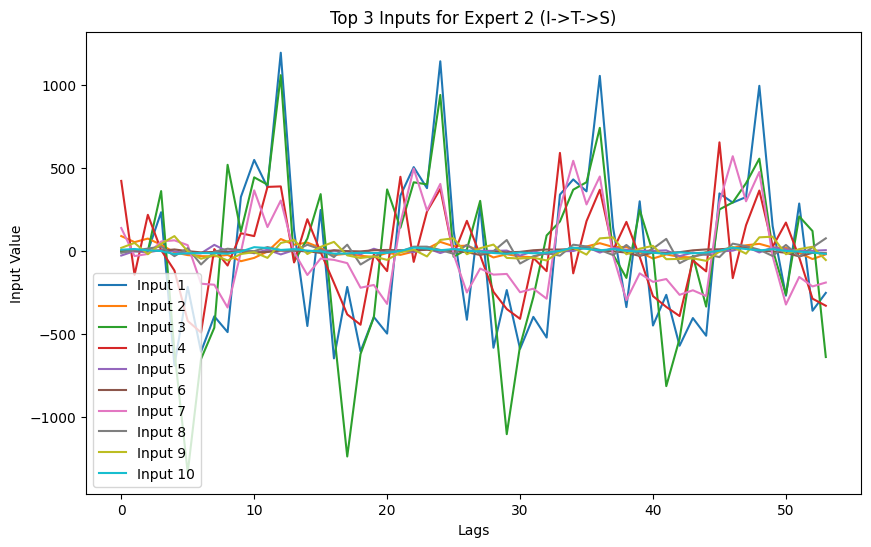

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 40.60it/s] 
sMAPE for seasonal: 0.21311563426930566


In [14]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_seasonal, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_seasonal)

smape_seasonal = calculate_smape(Y_test_seasonal, predictions, 'NBeatsStackMoe')
print(f'sMAPE for seasonal: {smape_seasonal}')

... and the remainder

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.05it/s, v_num=214, train_loss_step=208.0, train_loss_epoch=263.0, valid_loss=292.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 14.73it/s, v_num=214, train_loss_step=208.0, train_loss_epoch=263.0, valid_loss=292.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 135.43it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[ 873, 1042,  113],
        [ 292, 1143,  405],
        [ 846,  413,  538],
        [ 296, 1401,  262],
        [ 333, 1078,  592],
        [ 670,  954,  771],
        [ 819, 1174,  497],
        [1373,  795,  604],
        [ 168,  899,  639],
        [ 164,   30,  580]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.4580, 0.4489, 0.4438],
        [0.4542, 0.4251, 0.4421],
        [0.4469, 0.4222, 0.4408],
        [0.4462, 0.4213, 0.4407],
        [0.4448, 0.4205, 0.4339],
        [0.4409, 0.4196, 0.4333],
        [0.4382, 0.4176, 0.4318],
        [0.4380, 0.4166, 0.4293],
        [0.4379, 0.4163, 0.4290],
        [0.4371, 0.4152, 0.4283]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([  24.5354,    9.2764,   42.1801,   36.6675,   44.2736,   52.7773,
          10.2502,    5.8701,   47.4896,   43.6302,    1.1266,  -4

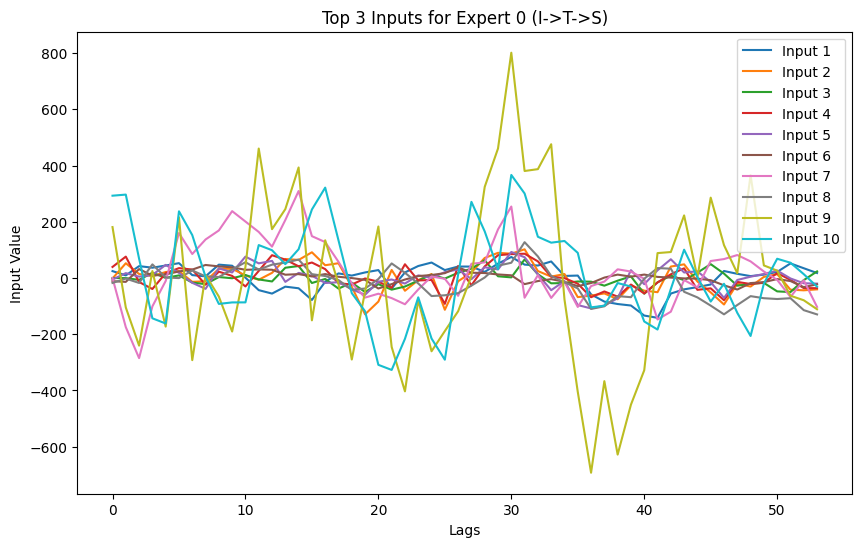

expert_top_inputs[:, 0]: tensor([    0.0000,     0.0000,     0.0000,     0.0000, -1062.3898, -1124.4642,
         2490.2415,  -635.7398,  1481.5780,   428.5852,  -541.2402,  -603.1094,
         -275.5728,  -423.9604, -1483.1646,   -10.2531,  3189.4241,  -818.8365,
          189.4800,  1377.6172, -1187.9034,  -123.6224,  1883.0403,  1091.4946,
        -1385.2449,  -291.2567, -1548.7156,  1151.2928, -1697.1213,  2741.4495,
        -2884.1494,  -180.2755,   984.5988,   -23.9469,  -782.9825,   615.9133,
         -239.3619,  1065.6271,   609.1536,  -363.1802, -1836.4598,  -546.5056,
          570.3953,  -550.8284,  1489.4104,   546.6179, -1296.9103, -1672.4834,
         2944.6819,  1201.3754,   110.6617, -1576.4236,  1439.9509,  -105.4011],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([ 1301.8047,    13.6672,   311.5276,  -852.0884, -1376.8317,  -786.9931,
         -235.9053,  -349.3288,    79.4323,   940.0289,   -40.9083,  -357.7505,
          417.6706,   639.8638,  -951.7213,  

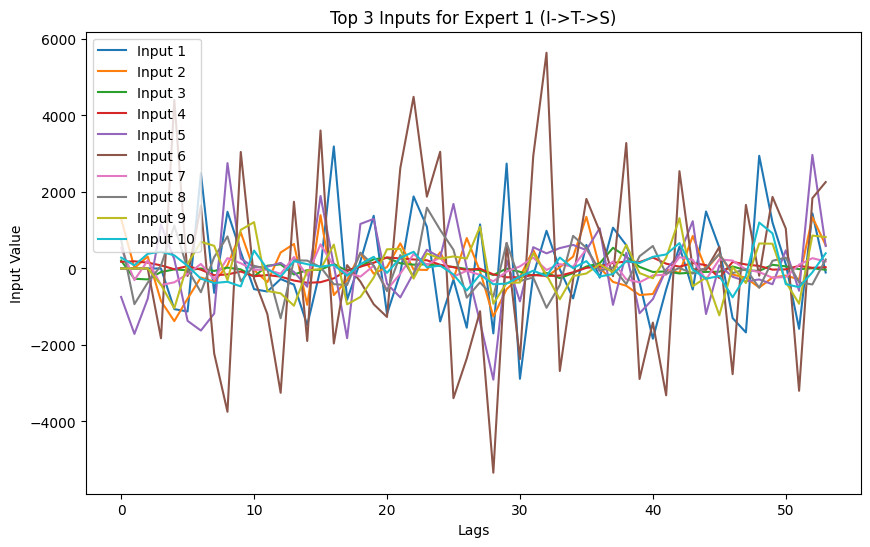

expert_top_inputs[:, 0]: tensor([ 10.4859,   8.0588,  -5.9433, -21.3734, -39.3607,   8.6243, -33.0884,
        -65.6638, -55.1072, -11.7333,   3.1002,  52.6972,  19.5994,   0.3344,
         -6.4260,  65.1413,  59.4333,  38.2878,  23.9763,   3.6242,  22.8696,
         81.6441,  77.9187,  14.2511,  -4.4147,  22.5505,  32.2603, -26.3148,
         19.4602, -47.1471,  -6.3234,  16.0690,  26.6851,  -1.2299,  28.9825,
         24.4155,  77.8493, 111.4775,  50.0770,  30.4915,  23.2990,  13.3685,
         18.0205,   6.3472,   5.9539,  63.4487,  36.9329, -23.5994, -31.3560,
        -37.6629, -57.0268, -59.4057, -73.4145,  37.4368], device='cuda:0')
expert_top_inputs[:, 1]: tensor([   0.0000,    0.0000,    0.0000,  116.2675, -214.7285,   73.5263,
        -124.9147,  167.2093, -540.7349,  313.8649,  -12.7650,  200.6203,
         306.9583,  188.8687, -216.5676,  235.2222,  -80.6778, -611.3495,
         217.5564,  281.3783,  -86.1480,  -62.6991,  234.4476, -285.8229,
         -80.6733,   40.7198, -2

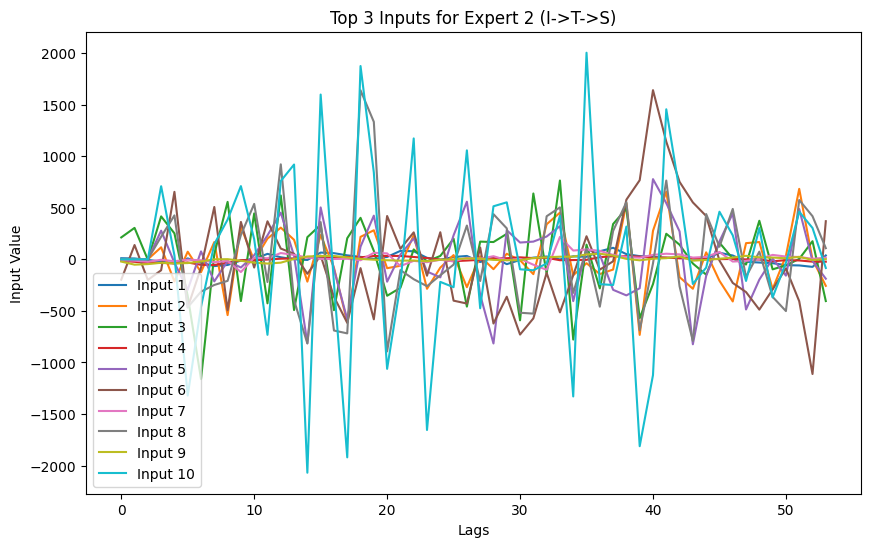

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 41.87it/s] 
sMAPE for remainder: 1.2955923932843496


In [15]:
prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq=1
)
nf.fit(df=Y_train_remainder, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=Y_test_remainder)

smape_remainder = calculate_smape(Y_test_remainder, predictions, 'NBeatsStackMoe')
print(f'sMAPE for remainder: {smape_remainder}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 60.2 K | train
4 | gate         | Sequential    | 273    | train
-------------------------------------------------------
57.8 K    Trainable params
2.7 K     Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)
34        Modules in train mode

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.04it/s, v_num=216, train_loss_step=513.0, train_loss_epoch=626.0, valid_loss=670.0]  

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 15.04it/s, v_num=216, train_loss_step=513.0, train_loss_epoch=626.0, valid_loss=670.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 147.13it/s]topk_indices shape: torch.Size([10, 3])
topk_indices: tensor([[1134, 1073, 1234],
        [ 969,  717,  926],
        [ 912, 1027, 1077],
        [ 436,  651,  927],
        [ 444,  550,   73],
        [ 848, 1115,  919],
        [ 884, 1109,  302],
        [ 443,  356,  375],
        [ 886,  603,  793],
        [ 889, 1292,  166]], device='cuda:0')
topk_values shape: torch.Size([10, 3])
topk_values: tensor([[0.6293, 0.6590, 0.6743],
        [0.5975, 0.6586, 0.6377],
        [0.5753, 0.6541, 0.6372],
        [0.5635, 0.6509, 0.6291],
        [0.5598, 0.6441, 0.6146],
        [0.5597, 0.6426, 0.6137],
        [0.5576, 0.6416, 0.6093],
        [0.5512, 0.6344, 0.6041],
        [0.5501, 0.6341, 0.6038],
        [0.5463, 0.6297, 0.6008]], device='cuda:0')
expert_top_inputs[:, 0]: tensor([4340., 4120., 4520., 4160., 4600., 5620., 3960., 4220., 4900., 4820.,
        4060., 4200., 2900., 3700., 4280., 3760., 4320., 5020.

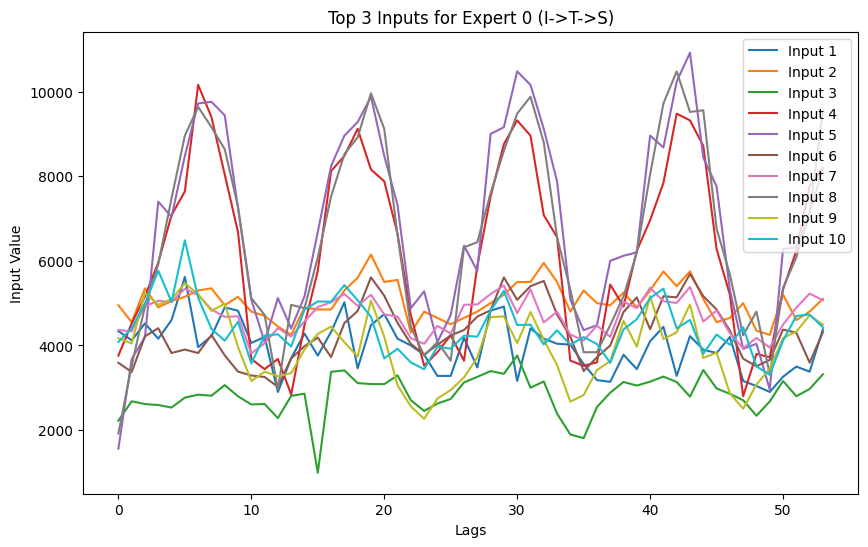

expert_top_inputs[:, 0]: tensor([    0.,     0.,     0.,  5440.,  3210.,  3430.,  4280.,  3480., 11670.,
         6240.,  7360.,  6170., 10070.,  7230., 10840.,  4330.,  5100.,  2570.,
         5100.,  4530.,  4220.,  5920.,  5510.,  5310.,  6300.,  2790.,  3110.,
         9240.,  4030.,  4200.,  3610.,  6250.,  4110.,  1940.,  4160.,  4920.,
         3840.,  3280.,  1460.,  2490.,  1710.,  2860.,  2890.,  1320.,  1020.,
         4450.,  2570.,  2600.,  2830.,  4320.,  1670.,  2620.,  6640.,  1870.],
       device='cuda:0')
expert_top_inputs[:, 1]: tensor([4540., 4660., 4840., 5260., 4640., 5020., 6420., 4300., 4680., 4540.,
        4240., 4540., 4740., 5160., 5200., 5420., 5140., 4600., 4800., 4840.,
        4720., 4600., 4340., 4460., 4360., 4720., 4920., 5000., 4680., 4480.,
        4840., 4480., 4500., 4380., 4460., 4540., 4920., 4600., 4880., 5120.,
        4560., 4520., 4600., 4580., 4360., 4540., 4420., 4680., 4760., 4940.,
        4780., 5340., 5140., 4700.], device='cuda:0')
e

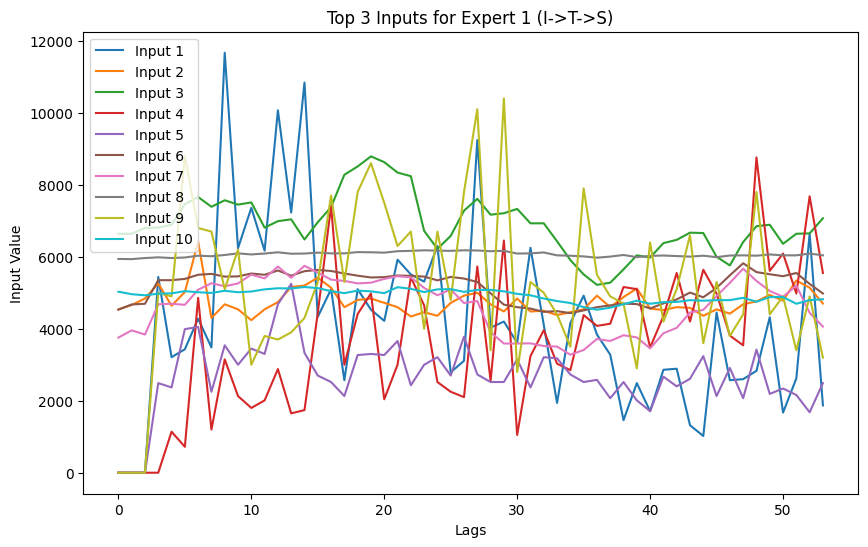

expert_top_inputs[:, 0]: tensor([3258., 2970., 3098., 3040., 3048., 2938., 3158., 3476., 2910., 2998.,
        2962., 3786., 4170., 2740., 3070., 3100., 3004., 2272., 2468., 2856.,
        3244., 2826., 3058., 3716., 3816., 3732., 3514., 3292., 3238., 2910.,
        2946., 2872., 3332., 4364., 4310., 4128., 3654., 4112., 4060., 4188.,
        3614., 3804., 3790., 4168., 3778., 4758., 3848., 4412., 4788., 4760.,
        4830., 4682., 4482., 4506.], device='cuda:0')
expert_top_inputs[:, 1]: tensor([6078., 6138., 6168., 6204., 6147., 6072., 6135., 6258., 6171., 6204.,
        6084., 6216., 6108., 6186., 6339., 6342., 6075., 5952., 5886., 6063.,
        6042., 6198., 6177., 6147., 6114., 6117., 6150., 6018., 6174., 6081.,
        6018., 6063., 6333., 6405., 6429., 6591., 6726., 6657., 6531., 6492.,
        6240., 6270., 5919., 6366., 6306., 6213., 6252., 6402., 6375., 6243.,
        6207., 6342., 6474., 6375.], device='cuda:0')
expert_top_inputs[:, 2]: tensor([7900., 7560., 8240., 7880., 8

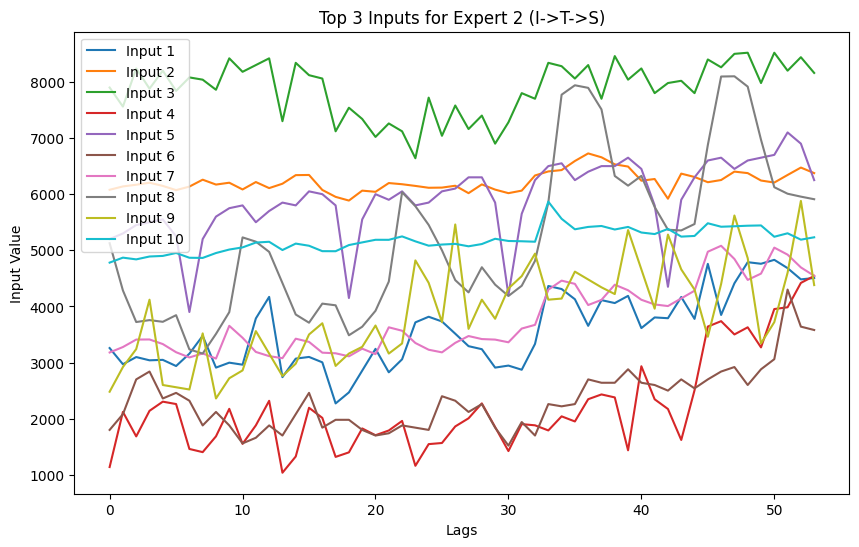

Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 35.21it/s] 
sMAPE for original: 0.14483947352433696


In [16]:
y_train, y_test = train_test_split(m3, horizon)

prob_collector = GateValuesCollectorCallback(is_stack=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            callbacks=[prob_collector],
        )
    ], 
    freq="M"
)
nf.fit(df=y_train, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=y_test)

smape_original = calculate_smape(y_test, predictions, 'NBeatsStackMoe')
print(f'sMAPE for original: {smape_original}')

In [17]:
# calculate the weights so that the sum of the smapes of the individual components is equal to the smape of the original series
import numpy as np
from scipy.optimize import minimize

components = np.array([smape_trend, smape_seasonal, smape_remainder])

# Objective: minimize squared error from target smape_original
def loss(w):
    return (np.dot(w, components) - smape_original)**2

# Constraints: weights sum to 1 and are non-negative
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(0, 1)] * 3

# Initial guess
w0 = np.array([1/3, 1/3, 1/3])

# Solve
res = minimize(loss, w0, bounds=bounds, constraints=constraints)

# Output
weights = res.x
weights_percent = weights * 100
print("components:", components)
print("Weights (%):", weights_percent)
print("sMAPE Original:", smape_original)


components: [0.06463146 0.21311563 1.29559239]
Weights (%): [54.82496265 43.9620577   1.21297965]
sMAPE Original: 0.14483947352433696
